In [173]:
import torch 
import torch.nn as nn 
import os 
import torchvision 
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets.utils import download_url
import tarfile
from tqdm import tqdm

In [8]:
dataset_url = "http://pjreddie.com/media/files/cifar.tgz"
download_url(dataset_url,'.')

In [9]:
with tarfile.open('./cifar.tgz','r:gz') as tar:
    tar.extractall(path='./cifdata')

In [13]:
data_dir = './cifdata/cifar'
#print(os.listdir(data_dir+"/train"))

In [14]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [20]:
classes = open("./cifdata/cifar/labels.txt").readlines()
import shutil

In [19]:
for c in classes:
    c = c.strip("\n")
    train_dir = "./cifdata/cifar/train/"
    test_dir = "./cifdata/cifar/test/"
    os.mkdir(path=train_dir+c)
    os.mkdir(path=test_dir+c)


        

In [28]:
for img in os.listdir(train_dir):
    if ".png" in img:
        c = img[:-4].split("_")[-1]
        #shutil.move(train_dir+img,train_dir+c+"/"+img)

In [27]:
for img in tqdm(os.listdir(test_dir)):
    if ".png" in img:
        c = img[:-4].split("_")[-1]
        shutil.move(test_dir+img,test_dir+c+"/"+img)

100%|██████████████████████████████████████████████████████████████████████████| 10010/10010 [00:08<00:00, 1180.25it/s]


In [34]:
dataset = ImageFolder(train_dir,transform = ToTensor())  # This actually loads the image when you want to access it.

### Image folder 
the image folder actually picks out and loads the image only when you do want to access it, so you avoid loading large amounts of data to the ram. 

In [33]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 32, 32]) 0


In [35]:
import matplotlib.pyplot as plt 
def show_example(img, label):
    print('label ', dataset.classes[label])
    plt.imshow(img.permute(1,2,0))
show_example(*dataset[0])

label  airplane


label  airplane


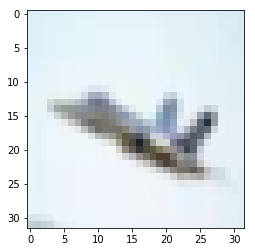

In [36]:
show_example(*dataset[0])

In [37]:
import numpy as np 
def split_indices(n, pct):
    n_val = int(n*pct)
    idx = np.random.permutation(n)
    
    return idx[n_val:], idx[:n_val]

In [38]:
train_indices, val_indices = split_indices(len(dataset), 0.2)
print(len(train_indices), len(val_indices))

40000 10000


In [174]:
train_sampler = SubsetRandomSampler(train_indices) # creates an object which samples randomly and exhaustively from train_indices 
train_dl = DataLoader(dataset, 100, sampler= train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, 100, sampler= val_sampler)


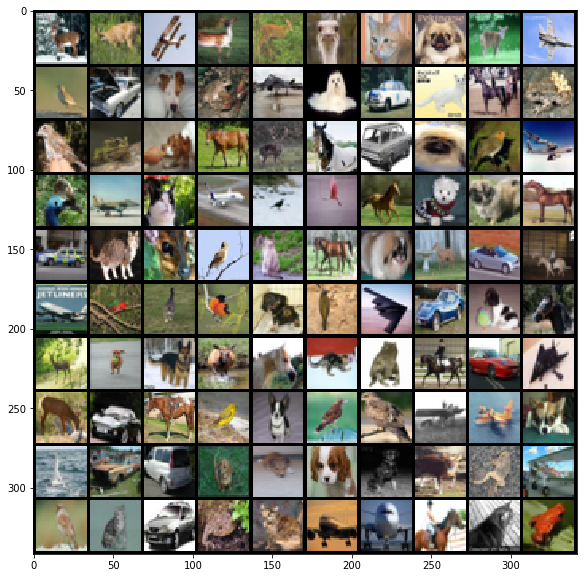

In [43]:
from torchvision.utils import make_grid 
def show_batch(dl):
    for xb, yb in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(make_grid(xb, 10).permute(1,2,0))
        break 

show_batch(train_dl)

## Convolutional neural network 

Convolutional neural networks take a convolution filter and creates filtered images. The filtered images are passed through to an activation function. the outputs are down sampled using pooling and passed to the next convolutional filters. 

Benefits are: 
1. Fewer connections. A small set of parameters (the kernel) is used to calculate the outputs, to the model has much fewer parameters compared to a fully connected layer 
2. Sparsity of connections. For each layer, each output element only depends on a small subset of input elements. 
3. Parameter sharing and spacial invariance. The features learned by a kernal in one part of the image can be used to detect similar pattern in a different part of another image

In [45]:
import torch.nn.functional as F 
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [46]:
for images, labels in train_dl:
    print("images.shape:", images.shape)
    out = simple_model(images)
    print("out.shape: ", out.shape)
    break

    # The output is now a feature map. 

images.shape: torch.Size([100, 3, 32, 32])
out.shape:  torch.Size([100, 8, 16, 16])


In [193]:
model = nn.Sequential(
    nn.Conv2d(3,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1 , padding =1 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1 , padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1 , padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Flatten()

)

In [194]:
model[0].weight.shape

torch.Size([16, 3, 3, 3])

In [195]:
for images, labels in train_dl: 
    print("image.shape: ", images.shape)
    out = model(images)
    out = F.softmax(out, dim=1)
    print("output.shape:" , out.shape)
    print("out[0]: ", out[0])
    print(torch.sum(out[0]))
    break 

image.shape:  torch.Size([100, 3, 32, 32])
output.shape: torch.Size([100, 16])
out[0]:  tensor([0.0605, 0.0685, 0.0620, 0.0605, 0.0605, 0.0605, 0.0605, 0.0622, 0.0646,
        0.0646, 0.0605, 0.0651, 0.0624, 0.0605, 0.0663, 0.0605],
       grad_fn=<SelectBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [61]:
# Now define some helpers to use the GPU 

def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl =dl
        self.device = device
    def __iter__(self):
        for b in self. dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [62]:
device = get_default_device()
device

device(type='cuda')

In [63]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

In [89]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric = None):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    
    if opt is not None: 
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None: 
        metric_result = metric(preds, yb)
        
    return loss, len(xb), metric_result 


def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb,yb,metric=metric) for xb, yb in val_dl]
    
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        
        avg_losses = np.sum(np.multiply(losses,nums))/total 
        
        avg_metrics = None
        if metric is not None:
            avg_metrics = np.sum(np.multiply(metrics, nums))/total 
        
        return avg_losses, total, avg_metrics

In [90]:
avg_losses, total,avg_metrics = evaluate(model, F.cross_entropy, val_dl, accuracy)

In [92]:
from tqdm import tqdm
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, lr = 0.001):
    
    train_losses = []
    val_losses = []
    val_metrics_list = []
    if opt_fn is None:
        opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr = lr)
    
    for epoch in range(epochs):
        for xb, yb in tqdm(train_dl):
            loss, num, metrics = loss_batch(model, loss_fn, xb,yb, opt = opt, metric = metric)
        
        train_losses.append(loss)
        
        val_loss, total, val_metrics = evaluate(model, loss_fn, val_dl, metric = metric)
        val_losses.append(val_loss)
        val_metrics_list.append(val_metrics)
        print("Epoch number %d/%d , loss = %.4f, %s = %.4f" %(epoch+1, epochs, val_loss, metric.__name__, val_metrics))
        
    return train_losses, val_losses, val_metrics_list

In [81]:
def accuracy(preds, yb):
    _, preds = torch.max(preds,dim = 1)
    
    return torch.sum(preds==yb)/len(yb)

In [82]:
num_epochs = 10 
opt_fn = torch.optim.Adam
lr = 0.005

In [93]:
train_losses, val_losses, val_metrics = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, opt_fn=opt_fn,metric = accuracy, lr = lr)

  0%|▍                                                                                 | 2/400 [00:00<00:21, 18.57it/s]

Epoch number 1/10 , loss = 1.0370, accuracy = 0.6813


  0%|▍                                                                                 | 2/400 [00:00<00:26, 14.85it/s]

Epoch number 2/10 , loss = 0.9113, accuracy = 0.7168


  0%|▍                                                                                 | 2/400 [00:00<00:26, 14.85it/s]

Epoch number 3/10 , loss = 0.7322, accuracy = 0.7706


  0%|▍                                                                                 | 2/400 [00:00<00:25, 15.79it/s]

Epoch number 4/10 , loss = 0.9559, accuracy = 0.7144


  0%|▍                                                                                 | 2/400 [00:00<00:23, 17.28it/s]

Epoch number 5/10 , loss = 0.7876, accuracy = 0.7629


  0%|▍                                                                                 | 2/400 [00:00<00:25, 15.92it/s]

Epoch number 6/10 , loss = 0.6111, accuracy = 0.8075


  0%|▍                                                                                 | 2/400 [00:00<00:27, 14.64it/s]

Epoch number 7/10 , loss = 0.6847, accuracy = 0.7904


  0%|▍                                                                                 | 2/400 [00:00<00:27, 14.48it/s]

Epoch number 8/10 , loss = 0.7183, accuracy = 0.7572


  0%|▍                                                                                 | 2/400 [00:00<00:26, 14.75it/s]

Epoch number 9/10 , loss = 0.6540, accuracy = 0.7946


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:18<00:00, 21.28it/s]


Epoch number 10/10 , loss = 0.5761, accuracy = 0.8210


In [133]:
def predict(img, model):
    img.unsqueeze_(dim=0)
    img= img.to("cuda",non_blocking=True)
    pred = model(img)
    _, pred = torch.max(pred,dim=1)
    img = img.squeeze(dim = 0).cpu()
    plt.imshow(img.permute(1,2,0))
    print("THe prediction is " + dataset.classes[pred])

The label is horse
THe prediction is horse


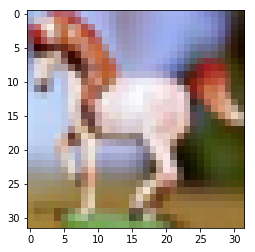

In [141]:
img, label = dataset[np.random.randint(len(dataset))]
print("The label is "+ dataset.classes[label])
predict(img,model)


In [145]:
test_dataset = ImageFolder(test_dir, transform=ToTensor())
test_loader = DeviceDataLoader(DataLoader(test_dataset, 100), device)

In [146]:
test_loss, _, test_acc = evaluate(model, F.cross_entropy, test_loader, metric = accuracy)

In [147]:
print(test_loss, test_acc)

tensor(7.8834, device='cuda:0') tensor(0.4670, device='cuda:0')


The label is frog
THe prediction is deer


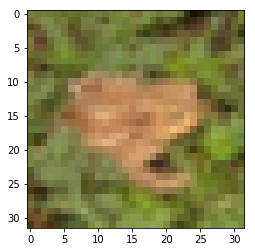

In [168]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print("The label is "+ dataset.classes[label])
predict(img,model)


## Loading and saving the model

In [169]:
torch.save(model.state_dict(), "cifar10-cnn.pth")

The exact same model must be created first in order to use this. 

In [170]:
model2 = nn.Sequential(
    nn.Conv2d(3,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1 , padding =1 ),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1 , padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1 , padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Flatten(),
    nn.Linear(16,10)
)

In [171]:
model2.load_state_dict(torch.load("cifar10-cnn.pth"))

<All keys matched successfully>